# Summary 

This is a very intesting TPS, and one that I have zero domain knowledge in.

Lets investigate the relevant [paper](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full) to understand a bit more about the data extraction process and the data itself

* v1 - Base Runthrough 
* v2 - Cross Validation of best model (ET) 
* v3 - Duplicates removed  

In [ ]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier,  Perceptron,PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from scipy.stats import mode


In [ ]:
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv", index_col = 0) 
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv", index_col = 0) 

# Understanding the problem 

The ask is to classifier bacteria types using features of DNA sequences/ segments

Each segment has 10 [nucleotides](https://en.wikipedia.org/wiki/Nucleotide) (like DNA units) written in sequential order with each having a variation of A T G and C nucleotides

i.e **ATATGGCCTT**  ,  **ATGTGACTTC**  etc etc......

If you are like me I got this far before the paper stopped making sense, so I tried to think of it in simple terms

#### Lets Imagine: 
* Each bacteria has a DNA structure like a necklace 
* Each necklace has different colored pearls (neucleotides)

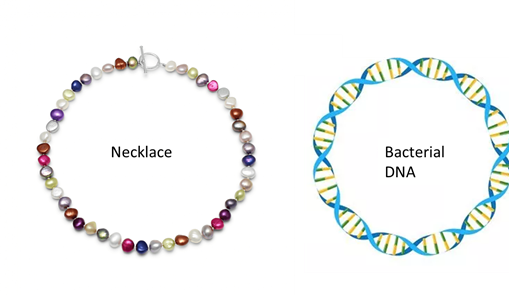

Lets now take a segment of this necklace of 10 pearls long (i.e 10 nucleotides long)

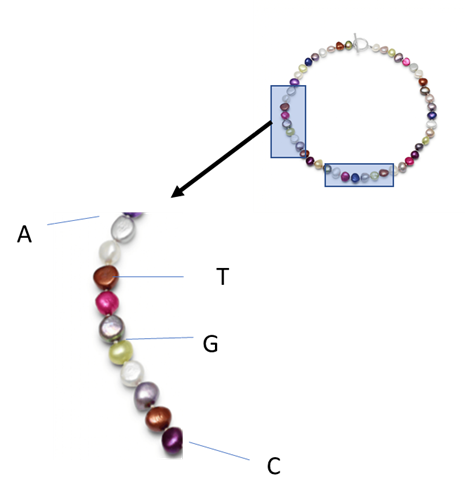

#### The ask is to **classify** the type of necklace (bacteria) by analysing multiple segments

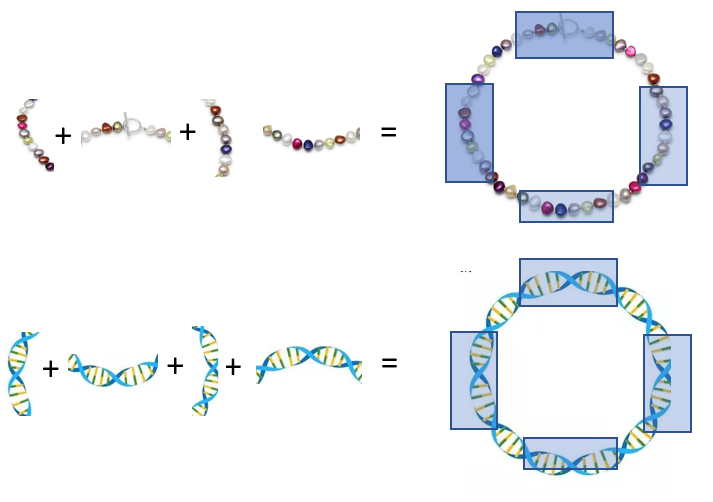


# Whats up with the data 

What we know: 

1. The features are **DNA segments** with a variation of possible 10 neucleotides i.e. ATATGGCCTT 
1. These neucleotides in each segment are counted and replesented in shorthand (removing the order) i.e. A2T4G2C2 
1. the Target column is the type of bacteria 

We can replesent each feature as a formula: \
A**w**T**x**G**y**C**z**  where 0 ≤ **w,x,y,z** ≤ k

#### Example of feature **A8T0G2C0**
A is present 8 times in the segment , T is 0 times, G is 2 times, C is 0 times

In [ ]:
train.head()

In [ ]:
print( "Total segments" , len( train.columns ) -1 ) 

# Whats up with the Values

The value of each element in the data follows the following process: 
* Each segment is used to produce a histogram of the distibution of neucleotides ( i.e. A = 8, T = 0 .....) 
* Each distribution is divided by the total number of segments (286)  --> **This gives the sequence-specific probability distribution function**
* The random bias is then subtracted from distibution probability --> **bias is generated by taking random sequence samples (bias spectrum)**

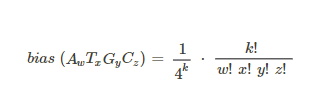

We now have a resulting DNA-sequence deviation spectrum. with each sample being the **probability distribution of that segment minus the bias**


The two imgaes below were taken from the paper and showcase the process above with respective of
1. The inital histogram (count of neucleotides in each segment) 
1. The bias subtracted from the histogram values 


<img src="https://www.frontiersin.org/files/Articles/496905/fmicb-11-00257-HTML/image_m/fmicb-11-00257-g002.jpg" width="800">

# Paper Machine Learning and Clustering Process

* The paper initially went through a clustering process with PCA to seperate/ cluster the bacteria species
* This was a decent result and is best shown through the below image 

##### it was also noted that noise/ error rate was added to the data and this didnt significantly affect the clustering negatively 

<img src="https://www.frontiersin.org/files/Articles/496905/fmicb-11-00257-HTML/image_m/fmicb-11-00257-g003.jpg" width="1000" height="600">


# Our Own EDA 

In [ ]:
train.shape

In [ ]:
train.duplicated().sum()

##### There are duplicates!
do we remove/ drop etc? 

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x= train["target"])
plt.xticks(rotation = "90")
display(train["target"].value_counts())

plt.show()

#### Note: Balanced data
However we are really pushing the boundaries here in terms of accuracy (top LB is 98%) \
potentially could look at certain weights or remove majority classes 

# Modelling 
We will use the same models present in the paper, with some additional feature engineering 

## Feature engineering 
as per https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start/notebook#Feature-engineering

In [ ]:
features = train.columns[:-1]

In [ ]:
def feature_engineering(df):
    
    df['mean'] = df[features].mean(axis=1)
    df['median'] = df[features].median(axis=1)
    df['q01'] = df[features].quantile(q=0.01, axis=1)
    df['q05'] = df[features].quantile(q=0.05, axis=1)
    df['q10'] = df[features].quantile(q=0.10, axis=1)
    df['q25'] = df[features].quantile(q=0.25, axis=1)
    df['q75'] = df[features].quantile(q=0.75, axis=1)
    df['q90'] = df[features].quantile(q=0.90, axis=1)
    df['q95'] = df[features].quantile(q=0.95, axis=1)
    df['q99'] = df[features].quantile(q=0.99, axis=1)
    df['max'] = df[features].max(axis=1)
    df['min'] = df[features].min(axis=1)
    
    df['std'] = df[features].std(axis=1)
    df['range'] = df['max'] - df['min']
    df['iqr'] = df['q75'] - df['q25']
    df['tails'] = df['range'] / df['iqr']
    df['dispersion'] = df['std'] / df['mean']
    df['dispersion_2'] = df['iqr'] / df['median']
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['median-max'] = df['median'] - df['max']
    df['median-min'] = df['median'] - df['min']
    df['q99-q95'] = df['q99'] - df['q95']
    df['q99-q90'] = df['q99'] - df['q90']
    df['q01-q05'] = df['q01'] - df['q05']
    df['q01-q10'] =  df['q01'] - df['q10']
    
    return df

feature_engineering(test)
feature_engineering(train)
features = [col for col in train.columns if col not in ['row_id', 'target']]

## Applying the Paper's Models 
* 11 models were used in the paper, we will try to simulate the same process on our data 
* 10 folds were used however to save run time we will only use Cross Validation for the "best" model and only use 5 folds
* Iterations are very low (10) so this is more of a quick test -  as I suspect 10 being too small for convergence to occur

In [ ]:
encoder = LabelEncoder()
train["target"] = encoder.fit_transform(train["target"])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
X = train.drop("target",axis =1)
y = train["target"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [ ]:
classifiers = {
                    'SGD': SGDClassifier(max_iter=1000,tol=1e-3,random_state=42),
                    'Perceptron': Perceptron(max_iter=10,tol=1e-3,random_state=42),
                    'Passive-Aggressive': PassiveAggressiveClassifier(max_iter=1000,tol=1e-3,random_state=123),
                    'Neural Network': MLPClassifier(max_iter=10,random_state=42),
                    'GNB': GaussianNB(),
                    'BNB': BernoulliNB(),
                    'RF': RandomForestClassifier(n_estimators = 10,max_features=None,bootstrap=False,random_state=42),
                    'ET': ExtraTreesClassifier(n_estimators = 10,max_features=None,bootstrap=False,random_state=42),
                    'GB': GradientBoostingClassifier(n_estimators = 10,max_features=None,random_state=42),
                    'LDA': LinearDiscriminantAnalysis(solver='svd'),
                    'QDA': QuadraticDiscriminantAnalysis()
                }

### Model Comparison 

In [ ]:
results = pd.DataFrame(index = classifiers.keys(), columns= ["Accuracy"],dtype="float64" )
test_preds = []

for name, model in classifiers.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    accuracy_train = accuracy_score(y_train, y_pred_train) 
    print("Accuracy on Train data: ", accuracy_train)
    
    accuracy_val = accuracy_score(y_test, y_pred) 
    print("Accuracy on Validation data: ", accuracy_val)

    results.loc[name ,"Accuracy Val"] = accuracy_val
    results.loc[name ,"Accuracy Train"] = accuracy_train

In [ ]:
results["Val>Train"] = results["Accuracy Val"] - results["Accuracy Train"]>0
results.sort_values(by= "Accuracy Val", ascending=False)

# Validation Accuracy is higher than Training! 

From our results we can see some models have a higher Validation than Training Accuracy \
We either have leakage wrt:

* Leakage in the added features ---- This doesnt seem to be the case 
* Our model has leakage in its build ---- multiple models used here so this cant be it either 
* High regularization could make validation "easier" to predict than training ------ no regularization 
* Train test split / Scaling leakage ---- none to be seen 
* Duplicate samples  across training and validation data --- **remember those duplicates noted above**!

In [ ]:
train.drop_duplicates(keep="first", inplace=True,ignore_index=True)

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x= train["target"])
plt.xticks(rotation = "90")
display(train["target"].value_counts())

plt.show()

# Best model CV
From previous runs we know that ET is the best model - we will increase the interations and run a CV 

In [ ]:
model = ExtraTreesClassifier(n_estimators = 1000,max_features=None,bootstrap=False,random_state=42)
#model = list(classifiers.values())[np.argmax(results["Accuracy"])]
model

In [ ]:
params = {}
model = ExtraTreesClassifier( n_estimators = 1000, bootstrap=True, random_state=42, **params)
scores = []
test_preds = []

for idx, (train_idx, val_idx) in enumerate( cv.split(X,y)):
    print (f"Running fold {idx}")
    
    X_train , X_test = X.iloc[train_idx] , X.iloc[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    scores.append(accuracy)
    print("Accuracy", accuracy) 
    
    test_preds.append(model.predict(test) ) 
    
print( "\nFinal Accuracy" , np.mean(accuracy)  )  

In [ ]:
print(classification_report(y_test,y_pred))

# Additonal Steps to improve 

* Extra Trees seems to come out on top - as it is overfitting (score on PB LB = 0.94) - should we regularize this?  
* Noise was added in the paper and this could help regularize the ET 
* Our data is not imbalanced however our accuracy is in the 90% so any small improvement is good  -- potentially apply imbalanced scoring metrics? 
* Clustering could also create additional features

# Submission 

In [ ]:
preds = encoder.inverse_transform(mode(test_preds)[0][0])

In [ ]:
sub = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv", index_col = 0)
sub["target"] = preds
sub.to_csv("submission.csv")
sub.head()